# Applications of FFT

In [46]:
import numpy as np
import matplotlib.pyplot as plt

## Derivatives

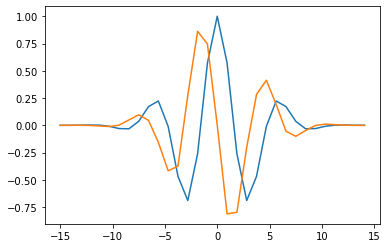

In [48]:
n = 32
L = 30
dx = L / n
x = np.arange(-L / 2, L / 2, dx, dtype="complex_")
# f(x)
f = np.cos(x) * np.exp(-np.power(x, 2) / 25)
# f'(x)
df = -(np.sin(x) * np.exp(-np.power(x, 2) / 25 + (2 / 25) * x * f))
plt.plot(x.real, f.real)
plt.plot(x.real, df.real)

dfFFT 0.04061775263549139
dfFD 0.09456647447771312


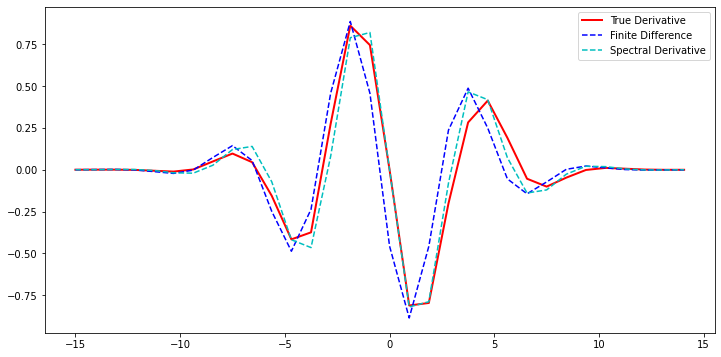

In [55]:
"""Approximate derivative by finite difference method"""
# discretizes the function into finite regions
dfFD = np.zeros(len(df), dtype='complex_')
for kappa in range(len(df) - 1):
    dfFD[kappa] = (f[kappa + 1] - f[kappa]) / dx

dfFD[-1] = dfFD[-2]

"""Approximate derivative by FFT"""
fhat = np.fft.fft(f)
# kappa: [-3, -2, -1, 0, 1, 2, 3] -> [0, 1, 2, 3, -3, -2, -1]
kappa = (2 * np.pi / L) * np.arange(-n / 2, n / 2)
kappa = np.fft.ifftshift(kappa)
# obtain real part of the function for plotting
dfhat = 1j * kappa * fhat
# Inverse Fourier Transform
dfFFT = np.real(np.fft.ifft(dfhat))

"""plot"""
print("dfFFT", np.abs(dfFFT - df).mean())
print("dfFD", np.abs(dfFD - df).mean())

plt.figure(figsize=(12, 6))
plt.plot(x.real, df.real, '-', color='r', linewidth=2, label='True Derivative')
plt.plot(x.real, dfFD.real, '--', color='b', linewidth=1.5, label='Finite Difference')
plt.plot(x.real, dfFFT.real, '--', color='c', linewidth=1.5, label='Spectral Derivative')
plt.legend()

## PDE

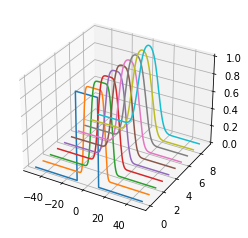

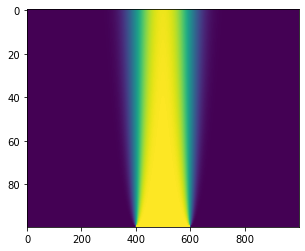

In [66]:
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d


a = 1    # Thermal diffusivity constant
L = 100  # Length of domain
N = 1000 # Number of discretization points
dx = L/N
x = np.arange(-L/2,L/2,dx) # Define x domain

# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Initial condition
u0 = np.zeros_like(x)
u0[int((L/2 - L/10)/dx):int((L/2 + L/10)/dx)] = 1
u0hat = np.fft.fft(u0)

# SciPy's odeint function doesn't play well with complex numbers, so we recast 
# the state u0hat from an N-element complex vector to a 2N-element real vector
u0hat_ri = np.concatenate((u0hat.real,u0hat.imag))

# Simulate in Fourier frequency domain
dt = 0.1
t = np.arange(0,10,dt)

def rhsHeat(uhat_ri,t,kappa,a):
    uhat = uhat_ri[:N] + (1j) * uhat_ri[N:]
    d_uhat = -a**2 * (np.power(kappa,2)) * uhat
    d_uhat_ri = np.concatenate((d_uhat.real,d_uhat.imag)).astype('float64')
    return d_uhat_ri

uhat_ri = odeint(rhsHeat, u0hat_ri, t, args=(kappa,a))

uhat = uhat_ri[:,:N] + (1j) * uhat_ri[:,N:]

u = np.zeros_like(uhat)

for k in range(len(t)):
    u[k,:] = np.fft.ifft(uhat[k,:])

u = u.real    

# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u_plot = u[0:-1:10,:]
for j in range(u_plot.shape[0]):
    ys = j*np.ones(u_plot.shape[1])
    ax.plot(x,ys,u_plot[j,:])
    
# Image plot
plt.figure()
plt.imshow(np.flipud(u), aspect=8)